# PSI solver using rational approximation

As an alternative to the integral eigenvalue problem, try to find the roots of the dispersion relation (solving $f(\omega)=0$ for complex frequency $\omega$) by doing a direct search in the complex plane (as in the terminal velocity solver). Problem with the dispersion relation $f$ of the full problem is that it is a beast to evaluate. Each evaluation requires numerically solving 9 integrals (complex, so really 18 integrals). And these are nasty integrals. We need to keep the number of evaluations of $f$ to a bare minimum. Moreover, since we *really* do not want to calculate an expression for $f'(\omega)$, root finding is limited to the secant method. Therefore we need to start the search *very* close to the actual root for the secant method to converge.

In the complex plane, several special techniques exist that do not work for $R^2$. Contour integration to identify roots, for example, see the [cxroots](https://rparini.github.io/cxroots/index.html) package. I found that to be too slow for our purposes. I settled for the rational approximation approach: given a few sample values of $f$, approximate it by a rational function. The zeros of the rational function should be close to the zeros of $f$. Use the zeros of the rational approximation as starting points for the secant search. 

## Inner workings

The class ```PSIMode``` can calculate the roots of the full dispersion relation. It takes an optional argument, ```n_sample```, specifying the number of function samples to calculate inside the domain (uniform randomly distributed, default=20). If no root is found using these samples, there is the option of zooming in on potential roots, specified by the optional argument ```max_zoom_level```. The algorithm will do a maximum of ```max_zoom_level``` iterations, each time adding another ```n_sample``` points close to the roots that were closest to growing. This turns out to be a powerful way of quickly zooming in on the roots of the exact dispersion relation. 

A good value of ```n_sample``` is one that gets the basic structure of the dispersion relation correct. For the PSI so far, I have never seen any improvement by going above 20. Moreover, for power law size distributions it seems that ```n_sample=10``` finds all the roots. It is the Birnstiel cratering bump that apparently creates some more intricate structure in the dispersion relation to warrant more sample points. I have never seen any improvement by taking ```max_zoom_level``` larger than 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from psi_mode import PSIMode

## Single size test

Create the PSI mode object with a single size at St=0.1 (if ```single_size_flag``` is ```True```, the first element of ```stokes_range``` is ignored). Random sampling of the domain is used, so make the results reproduceable by calling ```random.seed``` first. The search area in the complex plane is specified by ```real_range``` and ```complex_range```. Note that we are searching for growing modes only (positive imaginary parts). Need to stay away from the real axis because of a branch cut for wide size distributions. 

In [2]:
np.random.seed(0)
pm = PSIMode(dust_to_gas_ratio=3,
             stokes_range=[1.0e-8, 0.1],
             real_range=[-2, 2],
             imag_range=[1.0e-8, 1],
             single_size_flag=True)

Calculate the growing mode for the dust rich test case linA. 

In [3]:
roots = pm.calculate(wave_number_x=30, 
                     wave_number_z=30)
print("Roots: ", roots)

Roots:  [0.34801869+0.4190302j]


Plot the approximate dispersion relation (top) together with the exact dispersion relation (bottom). The latter is not recommended for a size range (*really* slow). In the top panel, sample points are indicated as circles. Red circles are the nodes of the rational approximation. 

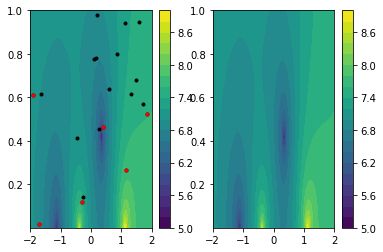

In [4]:
pm.plot_dispersion(wave_number_x=30,
                   wave_number_z=30,
                   show_exact=True)

## Polydisperse test

A more interesting test is an epicyclic mode that could not be done with the terminal velocity solver. 

In [5]:
np.random.seed(0)
pm = PSIMode(dust_to_gas_ratio=3,
             stokes_range=[1.0e-8, 0.01],
             real_range=[-2, 2],
             imag_range=[1.0e-8, 1])

In [6]:
roots = pm.calculate(wave_number_x=10,
                     wave_number_z=1000)
print("Roots: ", roots)

Roots:  [-1.00625799+1.32097848e-05j]


Seems to agree pretty well with the eigenvalue solver. It becomes more challenging when changing the maximum Stokes number to unity:

In [7]:
np.random.seed(0)
pm = PSIMode(dust_to_gas_ratio=3,
             stokes_range=[1.0e-8, 1],
             real_range=[-2, 2],
             imag_range=[1.0e-8, 1])

In [8]:
roots = pm.calculate(wave_number_x=0.1,
                     wave_number_z=10)
print("Roots: ", roots)

Roots:  [-1.00487995+0.00089464j]


The result appears to agree with one of the plots Colin sent.

## Arbitrary size distributions

The original version of PSIMode was limited to the MRN size distribution. Since all integrals are done numerically anyway, it is relatively straightforward to generalize to arbitrary size distributions. The function that is needed under the integrals is $F(s) = a_{\rm max} \sigma^0(a_{\rm max}s)/\rho_{\rm d}^0$, where $s = a/a_{\rm max} = \tau_{\rm s}/\tau_{\rm s,max}$. A simple ```SizeDensity``` class acts to wrap a size density function (i.e. $\sigma^0$) into $F(s)$. This class can be passed to ```PSIMode```. 

Below an example using ```get_sigma0_birnstiel_bump```.

In [9]:
import numpy as np
import scipy as sp

from psi_mode import PSIMode
from power_bump import get_sigma0_birnstiel_bump, get_birnstiel_discontinuity
from sizedensity import SizeDensity

First prepare the size density function:

In [10]:
amin = 1.0e-8
aL = 2.0/3.0*0.1
aP = 0.1
aR = 0.156
bumpfac = 2.0
epstot = 10.0
sigma0 = get_sigma0_birnstiel_bump(amin, aP, epstot, aL=aL, aR=aR, bumpfac=bumpfac)

It is worth noting that the value of ```epstot``` will be ignored (overridden by the dust to gas ratio in ```PSIMode```). Now create ```SizeDistribution``` object using $\sigma^0$ and the size range over which $\sigma^0$ exists:

In [11]:
sd = SizeDensity(sigma0, [amin, aR])

This size density has a kink, the position of which we want to give to the integration routines:

In [12]:
pole = get_birnstiel_discontinuity(amin, aP, aL=aL, aR=aR, bumpfac=bumpfac)
sd.poles = [pole]

Create a ```PSIMode``` object, passing our ```SizeDensity``` as the final optional parameter:

In [13]:
np.random.seed(0)
pm = PSIMode(dust_to_gas_ratio=epstot,
             stokes_range=[amin, aR],
             real_range=[-2, 2],
             imag_range=[1.0e-8, 1],
             n_sample=15,
             verbose_flag=False,
             single_size_flag=False,
             size_density=sd)

Find roots as usual:

In [14]:
Kx = 200
Kz = 1000
roots = pm.calculate(wave_number_x=Kx, wave_number_z=Kz)
print("Roots at Kx = {}, Kz = {}: {}".format(Kx, Kz, roots))

Roots at Kx = 200, Kz = 1000: [0.50795847+0.62221256j]


## Diffusion

Gas viscosity and associated dust diffusion, following Chen & Lin (2020), can be activated by passing a positive value  ```viscous_alpha``` to ```PSIMode.calculate```: 

In [16]:
roots = pm.calculate(wave_number_x=Kx, wave_number_z=Kz, viscous_alpha=1.0e-9)
print("Roots at Kx = {}, Kz = {}: {}".format(Kx, Kz, roots))

Roots at Kx = 200, Kz = 1000: [0.57801583+0.48583916j]
